# Social Media Use and its Impact on Human Emotion
## Andrea Francu
### Final project for DTSA 5509 Introduction to Machine Learning: Supervised Learning

This project takes a look at social media usage metrics and utilizes various models to attempt to accurately predict a user's mood. This problem can be approached in many ways, and this project uses linear regression, lasso and ridge regression, and random forest classifier to find the best method for achieving this goal. 

In [56]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

## EDA
The data set used is sourced from Kaggle and titled "Social Media Usage and Emotional Well-Being." 

This dataset can be found here: https://www.kaggle.com/datasets/emirhanai/social-media-usage-and-emotional-well-being/data?select=val.csv

This dataset contains 10 features (descriptions are paraphrased from the kaggle description):
- **User_ID**: User's unique identifier
- **Age**: User's age
- **Gender**: User's gender (Female, Male, Non-binary)
- **Platform**: Social media platform used
- **Daily_Usage_Time (minutes)**: Daily social media usage of the user on the platform
- **Posts_Per_Day**: Number of posts made by the user per day
- **Likes_Received_Per_Day**: Number of likes the user receives per day
- **Comments_Receiver_Per_Day**: Number of comments the user receives per day
- **Messages_Sent_Per_Day**: Number of messages the user sends per day
- **Dominant_Emotion**: User's dominant emotion during the day

`Dominant_Emotion` is the target variable for this project, and the goal is to find the most significant predictors of this feature and build a model that accurately predicts this emotion based on those features.

In [74]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
val = pd.read_csv("val.csv", on_bad_lines = 'skip') # bypasses error thrown due to an extra entry by removing the row

Note: This dataset comes with 3 files: test, train, and val (validation); however, combining these files into one and then splitting the data can help reduce any bias, as the method for splitting this data prior is not stated in the description.

In [75]:
data = pd.concat([train, test, val], ignore_index = True) 
data.info()
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1249 entries, 0 to 1248
Data columns (total 10 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   User_ID                     1249 non-null   object 
 1   Age                         1249 non-null   object 
 2   Gender                      1248 non-null   object 
 3   Platform                    1248 non-null   object 
 4   Daily_Usage_Time (minutes)  1248 non-null   float64
 5   Posts_Per_Day               1248 non-null   float64
 6   Likes_Received_Per_Day      1248 non-null   float64
 7   Comments_Received_Per_Day   1248 non-null   float64
 8   Messages_Sent_Per_Day       1248 non-null   object 
 9   Dominant_Emotion            1247 non-null   object 
dtypes: float64(4), object(6)
memory usage: 97.7+ KB


,User_ID,Age,Gender,Platform,Daily_Usage_Time (minutes),Posts_Per_Day,Likes_Received_Per_Day,Comments_Received_Per_Day,Messages_Sent_Per_Day,Dominant_Emotion
0,1,25,Female,Instagram,120.0,3.0,45.0,10.0,12.0,Happiness
1,2,30,Male,Twitter,90.0,5.0,20.0,25.0,30.0,Anger
2,3,22,Non-binary,Facebook,60.0,2.0,15.0,5.0,20.0,Neutral
3,4,28,Female,Instagram,200.0,8.0,100.0,30.0,50.0,Anxiety
4,5,33,Male,LinkedIn,45.0,1.0,5.0,2.0,10.0,Boredom


Now that the data is combined, we can take a look at some of the features and their characteristics.

**Data Size**: The data has 1249 entries, with 10 columns (parameters)

**Data Types**: `User_ID`, `Age`, `Gender`, `Platform`, `Messages_Sent_Per_Day`, and `Dominant_Emotion` are all objects, whereas `Daily_Usage_Time`, `Posts_Per_Day`, `Likes_Received_Per_Day`, and `Comments_Receiver_Per_Day` are float64 by default. Some of these data types need to be modified, as features like `Age` and `Messages_Sent_Per_Day` are numeric and should be treated as such.
___

## Data Cleaning
This section was performed *iteratively*, meaning that some of the data cleaning steps were performed after an initial model was made, due to discoveries that came out of these models that pointed to further steps that needed to be taken to clean and organize the data.

The first thing that can be done is dropping the **User_ID** column, because it doesn't provide any meaningful insight as a predictor.

In [76]:
data.drop(['User_ID'], axis = 1, inplace = True)
data.nunique()

Age                           19
Gender                        20
Platform                       8
Daily_Usage_Time (minutes)    34
Posts_Per_Day                 10
Likes_Received_Per_Day        55
Comments_Received_Per_Day     31
Messages_Sent_Per_Day         59
Dominant_Emotion               7
dtype: int64

To get a better idea of whats in each feature, nunique() can be used to see how many unique values are listed for each category. This summary indicates there may be something wrong with the gender category, since the Kaggle page stated 3 options for this category but there are 20 unique entries. A value count of the entries in this can give more insight into the issue:

In [77]:
data['Gender'].value_counts()

Gender
Female        415
Male          411
Non-binary    331
29             10
28             10
24              9
27              9
31              8
22              8
33              6
25              6
34              6
26              5
21              4
30              2
23              2
35              2
32              2
Marie           1
Facebook        1
Name: count, dtype: int64

It looks like some of the entries got set in the wrong column. It looks like these got mixed up mostly with the age column, which is right next to the Gender one. This can be confirmed by checking the value counts of the age column.

In [78]:
data['Age'].value_counts()

Age
28                                                      120
27                                                      116
29                                                      111
26                                                       88
22                                                       86
24                                                       84
31                                                       82
25                                                       79
21                                                       69
23                                                       68
33                                                       67
30                                                       51
32                                                       47
35                                                       46
34                                                       44
Female                                                   34
Male                                

A simple resolution for this issue is to swap age and gender anywhere that age is set to a value that should be in the gender category.

In [79]:
gender_age = data[(data['Age'] == 'Female') | (data['Age'] == 'Male') | (data['Age'] == 'Non-binary')] #  find the indices where data is swapped
data.loc[gender_age.index, ['Age', 'Gender']] = data.loc[gender_age.index, ['Gender', 'Age']].values # swap the values back to their correct location
data['Gender'].value_counts() 

Gender
Female        449
Male          444
Non-binary    354
Marie           1
Name: count, dtype: int64

Now Gender only has 1 value inputted that shouldn't be there. Rather than swapping around a ton of data and messing with it too much, since its just one value the row can be removed to avoid overcomplicating the issue.

In [80]:
data = data[data['Gender'] != 'Marie'] # remove the one incorrect entry
data['Age'].value_counts()

Age
28                                                      130
27                                                      125
29                                                      121
22                                                       94
24                                                       93
26                                                       93
31                                                       90
25                                                       85
21                                                       73
33                                                       73
23                                                       70
30                                                       53
34                                                       50
35                                                       48
32                                                       48
 işte mevcut veri kümesini 1000 satıra tamamlıyorum:      1
Facebook                            

The `Gender` column looks ok now, but the `Age` column needs some further error fixing. `Age` has 2 inputs that should not be there, but this can be fixed by simply converting all the categories that should be numeric but aren't to numeric. By setting the `to_numeric` parameter 'errors' to 'coerce', this converts any non number to a NaN, which can later be removed.

In [ ]:
data['Age'] = pd.to_numeric(data['Age'], errors = 'coerce') # convert Age entries to numeric
data['Messages_Sent_Per_Day'] = pd.to_numeric(data['Messages_Sent_Per_Day'], errors = 'coerce') # convert Messages_Sent_Per_Day to numeric

Now that those categories are taken care of, the remaining non numeric categories can be looked at and an unecessary rows can be removed.

In [82]:
data['Platform'].value_counts()

Platform
Instagram    302
Facebook     247
Twitter      244
LinkedIn     154
Snapchat     112
Telegram      98
Whatsapp      89
55             1
Name: count, dtype: int64

In [83]:
data = data[data['Platform'] != '55']
data['Platform'].value_counts()

Platform
Instagram    302
Facebook     247
Twitter      244
LinkedIn     154
Snapchat     112
Telegram      98
Whatsapp      89
Name: count, dtype: int64

In [84]:
data['Dominant_Emotion'].value_counts()

Dominant_Emotion
Neutral      257
Happiness    241
Anxiety      223
Sadness      199
Boredom      174
Anger        151
Agression      1
Name: count, dtype: int64

In [85]:
data = data[data['Dominant_Emotion'] != 'Agression'] # remove this category as it only has one entry
data = data.rename(columns = {'Daily_Usage_Time (minutes)': 'Daily_Usage_Time'}) # rename for simplicity

In [86]:
data.isna().sum()

Age                          1
Gender                       1
Platform                     1
Daily_Usage_Time             1
Posts_Per_Day                1
Likes_Received_Per_Day       1
Comments_Received_Per_Day    1
Messages_Sent_Per_Day        1
Dominant_Emotion             1
dtype: int64

In [87]:
data = data.dropna() # remove NA entries
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1245 entries, 0 to 1248
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Age                        1245 non-null   float64
 1   Gender                     1245 non-null   object 
 2   Platform                   1245 non-null   object 
 3   Daily_Usage_Time           1245 non-null   float64
 4   Posts_Per_Day              1245 non-null   float64
 5   Likes_Received_Per_Day     1245 non-null   float64
 6   Comments_Received_Per_Day  1245 non-null   float64
 7   Messages_Sent_Per_Day      1245 non-null   float64
 8   Dominant_Emotion           1245 non-null   object 
dtypes: float64(6), object(3)
memory usage: 97.3+ KB


### Feature Spread

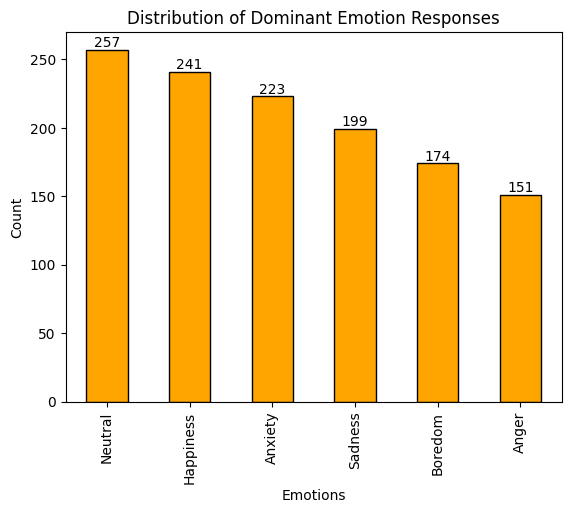

In [88]:
# visualize feature spread with bar plot
counts = data['Dominant_Emotion'].value_counts()
ax = counts.plot(kind = 'bar', color = 'orange', edgecolor = 'black', 
                                            title = 'Distribution of Dominant Emotion Responses', 
                                            xlabel = 'Emotions', ylabel = 'Count')

for i, value in enumerate(counts):
    ax.text(i, value, str(value), ha = 'center', va = 'bottom')

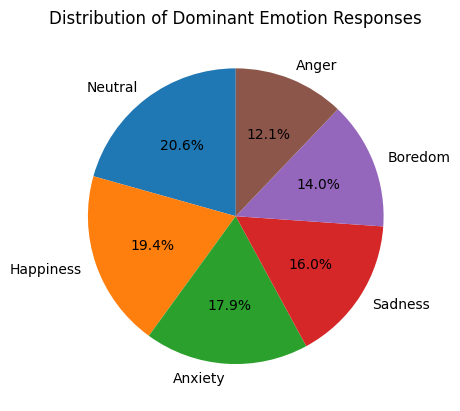

In [89]:
# visualize same data with pie chart
fig, ax = plt.subplots()
ax.pie(counts, labels=counts.index, autopct='%1.1f%%', startangle=90)
ax.set_title('Distribution of Dominant Emotion Responses')
plt.show()

These plots shows that the distribution of emotions shows a bit of class imbalance, which should be kept in mind when selecting a model.

The data is now cleaned and corrected, with NaN's removed. Any swapped data has either been swapped back or removed, and all categories are set to the correct data type. Up next is taking a look at which features are most significant, seeing if there's any interaction between features, and visualizing these possible interactions.
___

## Feature Engineering
Feature engineering involves looking at any interactions between features, modifying, removing, or adding features as needed to reduce any bias, and getting an idea of the best predictors of our response. This section is also modified *iteratively*, using feedback from the models formed later in the script to guide decisions made with feature engineering.

 To get an idea of the relationship between predictors, a pair plot can give good insight into this.

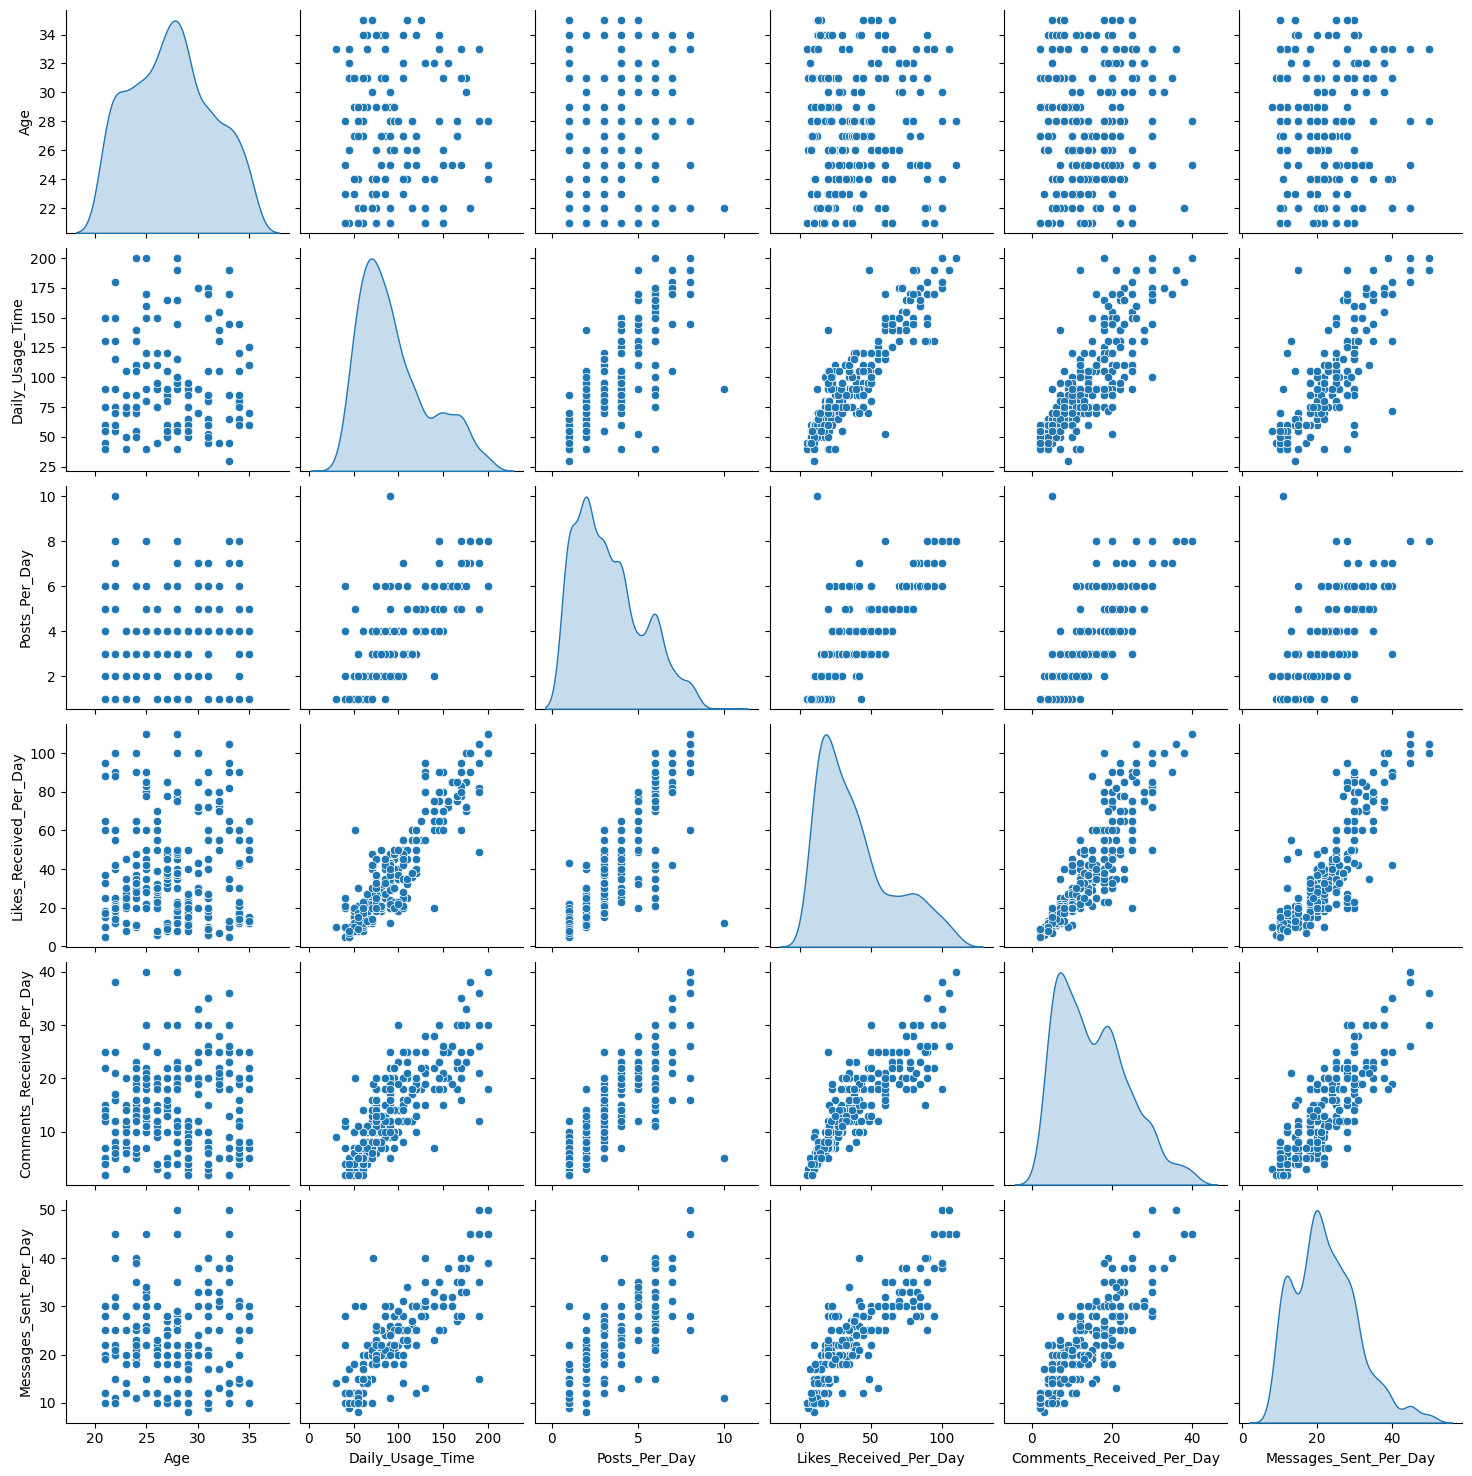

In [26]:
sns.pairplot(data, diag_kind = 'kde')

A few things to note from this pair plot: 
- `Age` does not seem to be related to any of the other numeric features.
- `Daily_Usage_Time`, `Posts_Per_Day`, `Likes_Received_Per_Day`, and `Comments_Received_Per_Day` all seem to be linearly positively related. This indicates that there may be some interaction between these features.

This only gives a look into our numeric variables however. So one way to deal with this is to turn the categorical variables numerical if possible. 

There are 2 features that fall into the category of **non-ordinal categorical variables**: gender and platform. This is because they are categories that don't have a meaninful order. One solution is to convert these categories into binary variables. First, new binary columns must be created for each option for these categories, which can be done with the pandas function get_dummies.

In [27]:
data = pd.get_dummies(data, columns = ['Gender'])
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1245 entries, 0 to 1248
Data columns (total 11 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Age                        1245 non-null   float64
 1   Platform                   1245 non-null   object 
 2   Daily_Usage_Time           1245 non-null   float64
 3   Posts_Per_Day              1245 non-null   float64
 4   Likes_Received_Per_Day     1245 non-null   float64
 5   Comments_Received_Per_Day  1245 non-null   float64
 6   Messages_Sent_Per_Day      1245 non-null   float64
 7   Dominant_Emotion           1245 non-null   object 
 8   Gender_Female              1245 non-null   uint8  
 9   Gender_Male                1245 non-null   uint8  
 10  Gender_Non-binary          1245 non-null   uint8  
dtypes: float64(6), object(2), uint8(3)
memory usage: 91.2+ KB


Due to an issue that comes up later in this script, where statsmodels variable names cannot contain special characters, Gender_Non-binary can be renamed here:

In [28]:
data = data.rename(columns = {'Gender_Non-binary': 'Gender_Non_binary'})

In [29]:
data = pd.get_dummies(data, columns = ['Platform'])
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1245 entries, 0 to 1248
Data columns (total 17 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Age                        1245 non-null   float64
 1   Daily_Usage_Time           1245 non-null   float64
 2   Posts_Per_Day              1245 non-null   float64
 3   Likes_Received_Per_Day     1245 non-null   float64
 4   Comments_Received_Per_Day  1245 non-null   float64
 5   Messages_Sent_Per_Day      1245 non-null   float64
 6   Dominant_Emotion           1245 non-null   object 
 7   Gender_Female              1245 non-null   uint8  
 8   Gender_Male                1245 non-null   uint8  
 9   Gender_Non_binary          1245 non-null   uint8  
 10  Platform_Facebook          1245 non-null   uint8  
 11  Platform_Instagram         1245 non-null   uint8  
 12  Platform_LinkedIn          1245 non-null   uint8  
 13  Platform_Snapchat          1245 non-null   uint8

One of the simplest first models to try is linear regression. For this, all the categories need to be numerical, including the response. One way to approach the Dominant_Emotion variable, is to use label encoding and group the emotions into 3 categories - Negative, Neutral, and Positive. This is because the variable is **ordinal categorical**, since the categories have meaningful order - or at least they can when we group them together into these 3 categories.

The positive category will be encoded as 1, with the data points marked as 'Happiness' included.
The neutral category will be encoded as 0, with 'Neutral' included.
And the negative category will be encoded as -1, with 'Anxiety', 'Sadness', 'Boredom', 'Anger', and 'Aggression' grouped into it.

There are many ways to approach grouping this data, but for efficiency and simplicity, these 3 groups are a starting point.

In [30]:
data['Dominant_Emotion'].value_counts()

Neutral      257
Happiness    241
Anxiety      223
Sadness      199
Boredom      174
Anger        151
Name: Dominant_Emotion, dtype: int64

Since other models used later in the project can use non numeric categories, the mapping for this is going to be done on a copy of the data. This binary dataframe will include encoded emotion, that can be used to make a linear regression model. The original data can then be used for other models that are more tuned for classification.

In [31]:
data_bin = data.copy()

In [32]:
emotion_mapping = {
    'Neutral': 0,   
    'Happiness': 1,    
    'Anxiety': -1,     
    'Sadness': -1, 
    'Boredom': -1,  
    'Anger': -1,  
    'Aggression': -1
}

data_bin['Encoded_Emotion'] = data_bin['Dominant_Emotion'].map(emotion_mapping)
data_bin = data_bin.drop(columns = ['Dominant_Emotion'])
data_bin.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1245 entries, 0 to 1248
Data columns (total 17 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Age                        1245 non-null   float64
 1   Daily_Usage_Time           1245 non-null   float64
 2   Posts_Per_Day              1245 non-null   float64
 3   Likes_Received_Per_Day     1245 non-null   float64
 4   Comments_Received_Per_Day  1245 non-null   float64
 5   Messages_Sent_Per_Day      1245 non-null   float64
 6   Gender_Female              1245 non-null   uint8  
 7   Gender_Male                1245 non-null   uint8  
 8   Gender_Non_binary          1245 non-null   uint8  
 9   Platform_Facebook          1245 non-null   uint8  
 10  Platform_Instagram         1245 non-null   uint8  
 11  Platform_LinkedIn          1245 non-null   uint8  
 12  Platform_Snapchat          1245 non-null   uint8  
 13  Platform_Telegram          1245 non-null   uint8

Now that all the data is numeric, a correlation matrix can help show relationships between predictors

In [33]:
correlation_matrix = data_bin.corr()
correlation_matrix

,Age,Daily_Usage_Time,Posts_Per_Day,Likes_Received_Per_Day,Comments_Received_Per_Day,Messages_Sent_Per_Day,Gender_Female,Gender_Male,Gender_Non_binary,Platform_Facebook,Platform_Instagram,Platform_LinkedIn,Platform_Snapchat,Platform_Telegram,Platform_Twitter,Platform_Whatsapp,Encoded_Emotion
Age,1.000000,0.093221,0.032007,0.068068,0.099465,0.104882,-0.038697,0.217168,-0.189592,-0.173497,0.103676,0.196076,-0.115643,0.057043,-0.088574,0.050971,-0.081473
Daily_Usage_Time,0.093221,1.000000,0.871729,0.932801,0.882833,0.896025,0.331066,-0.052422,-0.296831,-0.299914,0.831822,-0.371440,-0.026588,-0.133361,-0.143169,-0.053961,0.565848
Posts_Per_Day,0.032007,0.871729,1.000000,0.903585,0.897549,0.854427,0.302008,-0.011457,-0.309425,-0.342113,0.736625,-0.386134,-0.093407,-0.084904,0.019666,-0.038994,0.495523
Likes_Received_Per_Day,0.068068,0.932801,0.903585,1.000000,0.926594,0.903246,0.344662,-0.008286,-0.358216,-0.368165,0.846653,-0.373942,-0.097848,-0.103674,-0.075893,-0.025313,0.551634
Comments_Received_Per_Day,0.099465,0.882833,0.897549,0.926594,1.000000,0.876754,0.294085,0.042962,-0.358822,-0.376501,0.713866,-0.417467,-0.072459,-0.082730,0.066871,-0.006171,0.487516
Messages_Sent_Per_Day,0.104882,0.896025,0.854427,0.903246,0.876754,1.000000,0.272684,0.025724,-0.317712,-0.329690,0.725818,-0.422276,-0.012314,-0.024915,-0.071686,-0.006088,0.449682
Gender_Female,-0.038697,0.331066,0.302008,0.344662,0.294085,0.272684,1.000000,-0.558194,-0.471644,-0.310039,0.319295,-0.042776,0.015780,-0.219150,-0.003376,0.220688,0.158501
Gender_Male,0.217168,-0.052422,-0.011457,-0.008286,0.042962,0.025724,-0.558194,1.000000,-0.468360,-0.139124,-0.052263,0.051337,-0.234083,0.249388,0.194244,-0.063392,-0.085770
Gender_Non_binary,-0.189592,-0.296831,-0.309425,-0.358216,-0.358822,-0.317712,-0.471644,-0.468360,1.000000,0.478009,-0.284465,-0.009008,0.231971,-0.031674,-0.202841,-0.167633,-0.077631
Platform_Facebook,-0.173497,-0.299914,-0.342113,-0.368165,-0.376501,-0.329690,-0.310039,-0.139124,0.478009,1.000000,-0.280919,-0.186909,-0.156415,-0.145417,-0.245619,-0.138038,-0.138760


<AxesSubplot:>

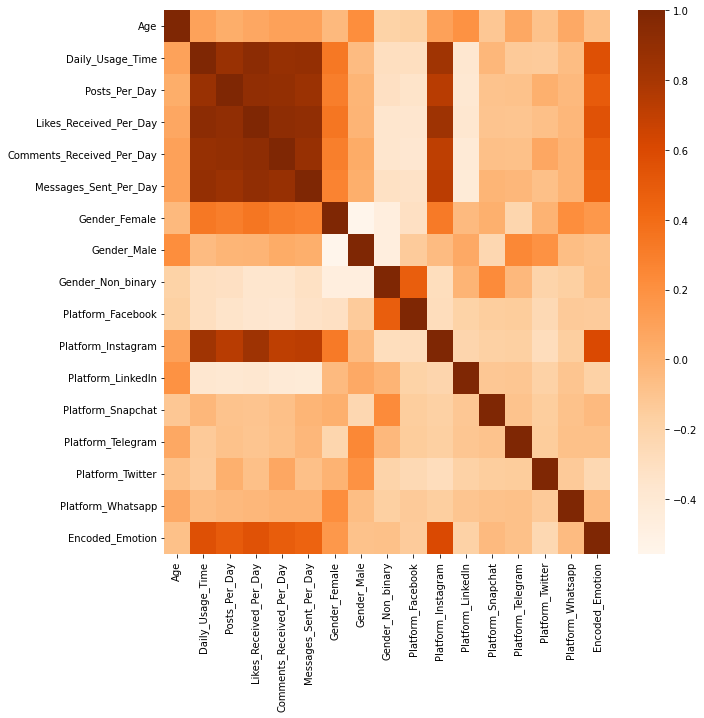

In [34]:
plt.figure(figsize = (10, 10))
sns.heatmap(correlation_matrix, cmap = "Oranges")

From this heatmap, there are a few features that seem to be highly correlated to emotion:
- Daily_Usage_Time
- Posts_Per_Day
- Comments_Received_Per_Day
- Messages_Sent_Per_day
- Platform_Instagram

All these features are also highly correllated with **each other**. This aligns with what was discovered in the initial pair plots. This indicates potential multicollinearity, and that all these predictors might not be necessary as they are representing redundant data.

When looking at the correllation coefficients, the largest one for emotion is Platform_Instagram, hinting that this might be one of the strongest predictors of emotion.

It is also interesting to note that the genders marked as female have a larger correllation to emotion than male and non-binary do.

Due to all these signs of collinearity, one path forward to avoid duplicate data is to combine some of these features. Posts_Per_Day, Likes_Received_Per_Day, Comments_Received_Per_Day, and Messages_Sent_Per_Day can be combined into one predictor, called Total_Activity. This way, the collinearity is reduced, but none of the data is removed. Note: this step was performed after initial models were made, in hopes of increasing model accuracy.

This can be done on both of the data frames.

In [35]:
data_bin['Total_Activity'] = (data_bin['Posts_Per_Day'] + data_bin['Likes_Received_Per_Day'] +
                              data_bin['Comments_Received_Per_Day'] + data_bin['Messages_Sent_Per_Day'])

data_bin.drop(['Posts_Per_Day', 'Likes_Received_Per_Day', 
               'Comments_Received_Per_Day', 'Messages_Sent_Per_Day'], axis = 1, inplace = True)
data_bin.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1245 entries, 0 to 1248
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Age                 1245 non-null   float64
 1   Daily_Usage_Time    1245 non-null   float64
 2   Gender_Female       1245 non-null   uint8  
 3   Gender_Male         1245 non-null   uint8  
 4   Gender_Non_binary   1245 non-null   uint8  
 5   Platform_Facebook   1245 non-null   uint8  
 6   Platform_Instagram  1245 non-null   uint8  
 7   Platform_LinkedIn   1245 non-null   uint8  
 8   Platform_Snapchat   1245 non-null   uint8  
 9   Platform_Telegram   1245 non-null   uint8  
 10  Platform_Twitter    1245 non-null   uint8  
 11  Platform_Whatsapp   1245 non-null   uint8  
 12  Encoded_Emotion     1245 non-null   int64  
 13  Total_Activity      1245 non-null   float64
dtypes: float64(3), int64(1), uint8(10)
memory usage: 60.8 KB


In [36]:
data['Total_Activity'] = (data['Posts_Per_Day'] + data['Likes_Received_Per_Day'] +
                              data['Comments_Received_Per_Day'] + data['Messages_Sent_Per_Day'])

data.drop(['Posts_Per_Day', 'Likes_Received_Per_Day', 
               'Comments_Received_Per_Day', 'Messages_Sent_Per_Day'], axis = 1, inplace = True)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1245 entries, 0 to 1248
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Age                 1245 non-null   float64
 1   Daily_Usage_Time    1245 non-null   float64
 2   Dominant_Emotion    1245 non-null   object 
 3   Gender_Female       1245 non-null   uint8  
 4   Gender_Male         1245 non-null   uint8  
 5   Gender_Non_binary   1245 non-null   uint8  
 6   Platform_Facebook   1245 non-null   uint8  
 7   Platform_Instagram  1245 non-null   uint8  
 8   Platform_LinkedIn   1245 non-null   uint8  
 9   Platform_Snapchat   1245 non-null   uint8  
 10  Platform_Telegram   1245 non-null   uint8  
 11  Platform_Twitter    1245 non-null   uint8  
 12  Platform_Whatsapp   1245 non-null   uint8  
 13  Total_Activity      1245 non-null   float64
dtypes: float64(3), object(1), uint8(10)
memory usage: 60.8+ KB


___

## Splitting the Data
Now that the data is cleaned and the features have been sorted to reduce interactions, and the categorical features have been encoded to all be numerical or binary in one of the data frames, it is time to split both our datasets into test and train to begin modeling. This uses a common 20% test and 80% train split.

In [37]:
X = data.drop(columns = ['Dominant_Emotion'])
y = data['Dominant_Emotion']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 123)
predictors = X.columns

print(f"Train set shape: {X_train.shape}")
print(f"Test set shape: {X_test.shape}")

test = pd.concat([X_test, y_test], axis = 1)
train = pd.concat([X_train, y_train], axis = 1)

Train set shape: (996, 13)
Test set shape: (249, 13)


In [38]:
X_bin = data_bin.drop(columns = ['Encoded_Emotion'])
y_bin = data_bin['Encoded_Emotion']

X_train_bin, X_test_bin, y_train_bin, y_test_bin = train_test_split(X_bin, y_bin, test_size = 0.2, random_state = 123)
predictors = X.columns

print(f"Train set shape: {X_train_bin.shape}")
print(f"Test set shape: {X_test_bin.shape}")

test_bin = pd.concat([X_test_bin, y_test_bin], axis = 1)
train_bin = pd.concat([X_train_bin, y_train_bin], axis = 1)

Train set shape: (996, 13)
Test set shape: (249, 13)


___

## Modeling Time!
Now it's time to build the models. The different models tested here include linear regression, lasso and ridge regression, and random forest classifier. 

### Linear Regression
Since not much is known about data, the simplest first method to try is a linear regression model. One approach to building the best linear regression model is to build four models, with different feature selection methods. These methods will be **forward selection**, **backward selection** and **mixed selection**, as well as a model using all the available predictors, and then comparing the four models. 

### All the Predictors
For the first model, a simple model can be made using all the predictors available:

In [39]:
predictors

Index(['Age', 'Daily_Usage_Time', 'Gender_Female', 'Gender_Male',
       'Gender_Non_binary', 'Platform_Facebook', 'Platform_Instagram',
       'Platform_LinkedIn', 'Platform_Snapchat', 'Platform_Telegram',
       'Platform_Twitter', 'Platform_Whatsapp', 'Total_Activity'],
      dtype='object')

In [40]:
formula = f"Encoded_Emotion ~ {' + '.join(predictors)}"
all_predictors = smf.ols(formula = formula, data = train_bin).fit()

In [41]:
all_predictors.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        Encoded_Emotion   R-squared:                       0.426
Model:                            OLS   Adj. R-squared:                  0.420
Method:                 Least Squares   F-statistic:                     66.50
Date:                Fri, 11 Oct 2024   Prob (F-statistic):          9.63e-111
Time:                        20:06:36   Log-Likelihood:                -911.17
No. Observations:                 996   AIC:                             1846.
Df Residuals:                     984   BIC:                             1905.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             -0.1549      0.111     -1.398      0.162      -0.372       0.063
Age                   -0.0280      0.005     -5.262      0.000      -0.038      -0.018
Daily_Usage_Time       0.0066      0.002      4.073      0.000       0.003       0.010
Gender_Female         -0.1371      0.047     -2.904      0.004      -0.230      -0.044
Gender_Male           -0.0781      0.051     -1.518      0.129      -0.179       0.023
Gender_Non_binary      0.0603      0.049      1.232      0.218      -0.036       0.156
Platform_Facebook     -0.1780      0.052     -3.448      0.001      -0.279      -0.077
Platform_Instagram     0.6424      0.086      7.488      0.000       0.474       0.811
Platform_LinkedIn     -0.1311      0.065     -2.023      0.043      -0.258      -0.004
Platform_Snapchat     -0.1338      0.064     -2.102      0.036      -0.259      -0.009
Platform_Telegram     -0.0624      0.066     -0.939      0.348      -0.193       0.068
Platform_Twitter      -0.2826      0.046     -6.173      0.000      -0.372      -0.193
Platform_Whatsapp     -0.0093      0.071     -0.131      0.896      -0.149       0.131
Total_Activity        -0.0010      0.001     -0.650      0.516      -0.004       0.002
==============================================================================
Omnibus:                       13.713   Durbin-Watson:                   1.946
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               22.008
Skew:                           0.062   Prob(JB):                     1.66e-05
Kurtosis:                       3.718   Cond. No.                     6.96e+17
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 3.99e-29. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

A few things of note from this summary:
- The model gives an $R^2$ value of 0.426. This is a metric of how much of the total variance can be explained by the model. 0.424 is generally not a good $R^2$ value. However, since this project is looking at psychological data as the response, rather than something mathematical, these datasets tend to have less explained variance.
- There are also several predictors with high p-values, indicating that many of the predictors are not significant.

Upon these initial observations, it does not seem like this is a good model for our data.

- Theres is an F-statistic of 66.5, with a p-value of 9.63e-111. This indicates that the predictors as a group are statistically significant, and explain a significant portion of the variance in our response, even if this model is not the best fit.

### Backward Selection
Another approach to try is **backward selection**, starting with all the predictors and removing them one by one based on their p-values.

From the all_predictors model above, the predictors with large p-values, indicating that they are not significant predictors, include Posts_Per_Day, Likes_Received_Per_Day, Gender_Female, Gender_Male, Platform_LinkedIn, Platform_Snapchat, Platform_Telegram, and Platform_Whatsapp. Backward selection should always be approached by removing predictors one by one, and recalculating the p-values.

This can be done with the following function:

In [42]:
def backward_selection(data, predictors, alpha):
    while True:
        formula = f"Encoded_Emotion ~ {' + '.join(predictors)}"
        model = smf.ols(formula = formula, data = data).fit()
        p_values = model.pvalues[1:]
        max_p_value = p_values.max()
        if max_p_value < alpha:
            break

        predictor_to_remove = p_values.idxmax()
        predictors = predictors.drop(predictor_to_remove)

        print(f"Removing: {predictor_to_remove}, P-value: {max_p_value}")
        
    return model, predictors

In [43]:
backward_model, backward_predictors = backward_selection(train_bin, predictors, alpha = 0.05)

Removing: Platform_Whatsapp, P-value: 0.8961791307044786
Removing: Platform_Telegram, P-value: 0.6163182436733856
Removing: Total_Activity, P-value: 0.5255216711383588
Removing: Gender_Non_binary, P-value: 0.3791576258772811
Removing: Platform_LinkedIn, P-value: 0.33227267459159515
Removing: Platform_Snapchat, P-value: 0.46940854941584487
Removing: Platform_Facebook, P-value: 0.22957073282719556


In [44]:
backward_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        Encoded_Emotion   R-squared:                       0.424
Model:                            OLS   Adj. R-squared:                  0.421
Method:                 Least Squares   F-statistic:                     121.5
Date:                Fri, 11 Oct 2024   Prob (F-statistic):          5.73e-115
Time:                        20:06:36   Log-Likelihood:                -912.97
No. Observations:                 996   AIC:                             1840.
Df Residuals:                     989   BIC:                             1874.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             -0.2703      0.153     -1.767      0.078      -0.571       0.030
Age                   -0.0270      0.005     -5.270      0.000      -0.037      -0.017
Daily_Usage_Time       0.0059      0.001      6.521      0.000       0.004       0.008
Gender_Female         -0.1568      0.054     -2.919      0.004      -0.262      -0.051
Gender_Male           -0.1086      0.053     -2.048      0.041      -0.213      -0.005
Platform_Instagram     0.7113      0.085      8.346      0.000       0.544       0.878
Platform_Twitter      -0.1857      0.054     -3.412      0.001      -0.293      -0.079
==============================================================================
Omnibus:                       14.602   Durbin-Watson:                   1.953
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               23.795
Skew:                           0.069   Prob(JB):                     6.81e-06
Kurtosis:                       3.744   Cond. No.                         862.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

- This model actuall results in a similar but even lower $R^2$ value, of 0.424, indicating that this models is not predicting more of the variance than we were with our original model. 
- There is an even higher F-statistic than the previous model. It is 121.5, which means that this model as a whole is better at explaining the variance in the response. This also means that our the $R^2$ might just be due to the fact that there are less predictors. This is confirmed with the adjusted $R^2$ of the models (which adjusts for number of predictors), which are both very close together, with this model's adjusted $R^2$ slightly larger.

### Forward Selection
The next method used forward selection, which works by adding predictors one by one based on their $R^2$ values.

In [45]:
def forward_selection(data, predictors):

    best_predictors = []
    best_r_2 = 0

    for predictor in predictors:
        
        formula = f"Encoded_Emotion ~ {' + '.join(best_predictors + [predictor])}"
        model = smf.ols(formula = formula, data = data).fit()
        if model.rsquared > best_r_2:
            best_predictors.append(predictor)
            best_r_2 = model.rsquared
            print(f"Adding predictor: {predictor} with R^2 value: {round(best_r_2,3)}")
            
    return model, predictors

In [46]:
forward_model, forward_predictors = forward_selection(train_bin, predictors)

Adding predictor: Age with R^2 value: 0.005
Adding predictor: Daily_Usage_Time with R^2 value: 0.354
Adding predictor: Gender_Female with R^2 value: 0.355
Adding predictor: Gender_Male with R^2 value: 0.36
Adding predictor: Gender_Non_binary with R^2 value: 0.36
Adding predictor: Platform_Facebook with R^2 value: 0.36
Adding predictor: Platform_Instagram with R^2 value: 0.418
Adding predictor: Platform_LinkedIn with R^2 value: 0.418
Adding predictor: Platform_Snapchat with R^2 value: 0.418
Adding predictor: Platform_Telegram with R^2 value: 0.42
Adding predictor: Platform_Twitter with R^2 value: 0.426
Adding predictor: Total_Activity with R^2 value: 0.426


In [47]:
forward_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        Encoded_Emotion   R-squared:                       0.426
Model:                            OLS   Adj. R-squared:                  0.420
Method:                 Least Squares   F-statistic:                     66.50
Date:                Fri, 11 Oct 2024   Prob (F-statistic):          9.63e-111
Time:                        20:06:36   Log-Likelihood:                -911.17
No. Observations:                 996   AIC:                             1846.
Df Residuals:                     984   BIC:                             1905.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             -0.1619      0.136     -1.191      0.234      -0.429       0.105
Age                   -0.0280      0.005     -5.262      0.000      -0.038      -0.018
Daily_Usage_Time       0.0066      0.002      4.073      0.000       0.003       0.010
Gender_Female         -0.1394      0.051     -2.743      0.006      -0.239      -0.040
Gender_Male           -0.0804      0.059     -1.372      0.170      -0.195       0.035
Gender_Non_binary      0.0580      0.058      1.006      0.314      -0.055       0.171
Platform_Facebook     -0.1687      0.098     -1.713      0.087      -0.362       0.025
Platform_Instagram     0.6517      0.106      6.138      0.000       0.443       0.860
Platform_LinkedIn     -0.1218      0.101     -1.200      0.230      -0.321       0.077
Platform_Snapchat     -0.1245      0.104     -1.198      0.231      -0.328       0.079
Platform_Telegram     -0.0531      0.106     -0.501      0.616      -0.261       0.155
Platform_Twitter      -0.2733      0.088     -3.122      0.002      -0.445      -0.102
Total_Activity        -0.0010      0.001     -0.650      0.516      -0.004       0.002
==============================================================================
Omnibus:                       13.713   Durbin-Watson:                   1.946
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               22.008
Skew:                           0.062   Prob(JB):                     1.66e-05
Kurtosis:                       3.718   Cond. No.                     1.68e+17
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 6.81e-28. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

This model is pretty similar to the model with all the predictors.
- The adjusted $R^2$ is still 0.420.
- The F-statistic is around 66, closer to the first model. 
This is likely because this model ended up selecting every predictor except for one, so not much difference will be noted between this and the full model.

### Mixed Selection
The final model is going to combine the two previous methods, into **mixed selection**. This consists of adding predictors that increase the $R^2$ of the model, while removing predictors with large p-values.

One way to do this is to simply use the model created with forward selection, and then put it into the backward selection function.

In [48]:
mixed_model, mixed_predictors = backward_selection(train_bin, forward_predictors, alpha = 0.05)

Removing: Platform_Whatsapp, P-value: 0.8961791307044786
Removing: Platform_Telegram, P-value: 0.6163182436733856
Removing: Total_Activity, P-value: 0.5255216711383588
Removing: Gender_Non_binary, P-value: 0.3791576258772811
Removing: Platform_LinkedIn, P-value: 0.33227267459159515
Removing: Platform_Snapchat, P-value: 0.46940854941584487
Removing: Platform_Facebook, P-value: 0.22957073282719556


In [49]:
mixed_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        Encoded_Emotion   R-squared:                       0.424
Model:                            OLS   Adj. R-squared:                  0.421
Method:                 Least Squares   F-statistic:                     121.5
Date:                Fri, 11 Oct 2024   Prob (F-statistic):          5.73e-115
Time:                        20:06:36   Log-Likelihood:                -912.97
No. Observations:                 996   AIC:                             1840.
Df Residuals:                     989   BIC:                             1874.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             -0.2703      0.153     -1.767      0.078      -0.571       0.030
Age                   -0.0270      0.005     -5.270      0.000      -0.037      -0.017
Daily_Usage_Time       0.0059      0.001      6.521      0.000       0.004       0.008
Gender_Female         -0.1568      0.054     -2.919      0.004      -0.262      -0.051
Gender_Male           -0.1086      0.053     -2.048      0.041      -0.213      -0.005
Platform_Instagram     0.7113      0.085      8.346      0.000       0.544       0.878
Platform_Twitter      -0.1857      0.054     -3.412      0.001      -0.293      -0.079
==============================================================================
Omnibus:                       14.602   Durbin-Watson:                   1.953
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               23.795
Skew:                           0.069   Prob(JB):                     6.81e-06
Kurtosis:                       3.744   Cond. No.                         862.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

- The adjusted $R^2$ is 0.421, similar to all the previous models.
- The F-statistic is large again, at 121.5, with a very small p-value.
- And there aren't any predictors with p values greater than 0.05.
- However, there is a p-value of 0.078 on the intercept - this shows that baseline emotion is not significantly significant when all the predictors are zero.

Note: before combining some of the predictors that indicated collinearity into one predictor, the p-value on the intercept here was actually 0.88, much worse than it is now. This shows that having those collinear predictors was negatively impacting the model accuracy.

One plot that can be useful is the residuals vs. predicted values plot. This can show if there are any patterns in the data and if the data shows signs of nonlinearity or homoscedasticity.

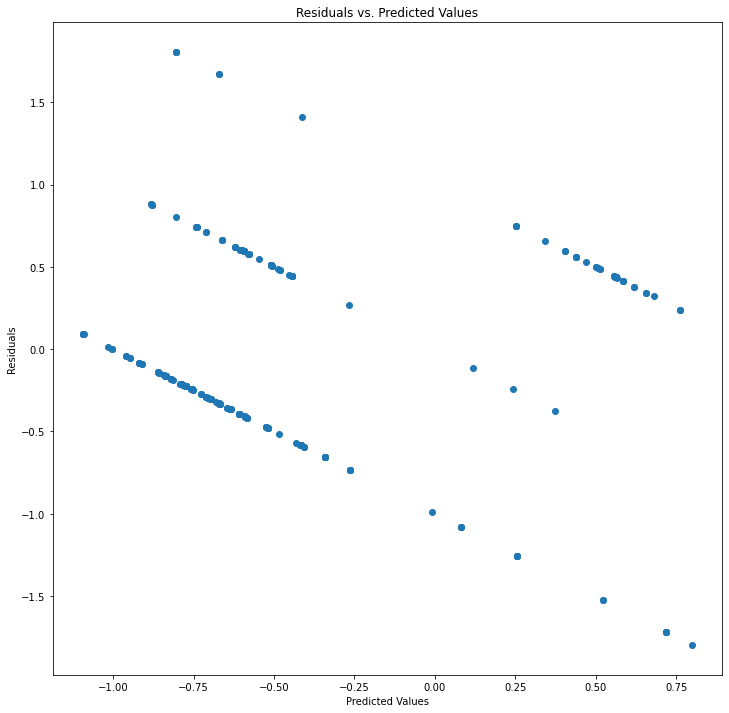

In [50]:
predictions = mixed_model.predict(X_test_bin)
residuals = y_test_bin - predictions

plt.figure(figsize = (12, 12))
plt.scatter(predictions, residuals)
plt.title('Residuals vs. Predicted Values')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.show()

The three angled lines shows that there is some definite signs of nonlinearity within the data. Rather than being scattered around the horizontal line at 0, the values follow distinct lines.

None of these four models seem to be a great fit for this data; however, the large F-statistics do indicate that the predictors are useful for predicting the response, but the data is likely just not linear. Other methods that are more flexible to collinearity, and can handle classification data, like the emotion variable, are ridge and lasso regression.

### Ridge and Lasso Regression

An advantage to using ridge and lasso methods, is that they weigh predictors by penalizing those that are not significant and boosting those that are. Another advantage is that they can even use classification data like the emotion response, and give a better prediction than just the encoded emotion from the linear regression.

#### Ridge Regression

In [51]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

ridge = LogisticRegression(penalty = 'l2', multi_class = 'multinomial', max_iter = 1000)
ridge.fit(X_train_scaled, y_train)

LogisticRegression(max_iter=1000, multi_class='multinomial')

When first running this model, the following error came up:

ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Even with 1000 max iterations, which indicated that this is due to improperly scaled data. This is fixed by using Standard Scaler to properly scale the data and allowed the model to be made.

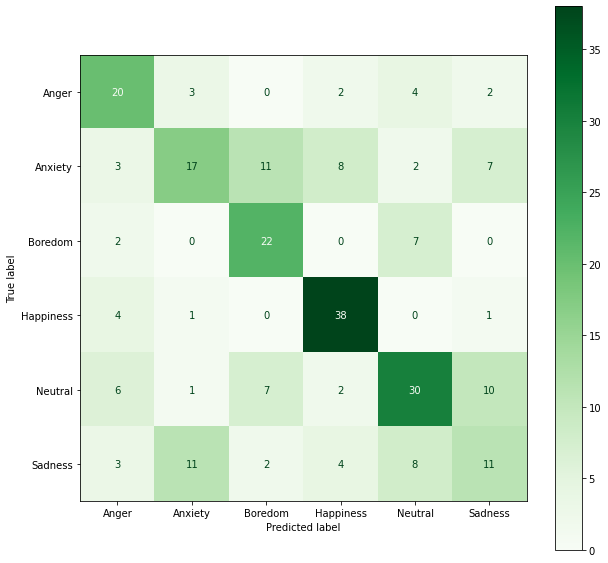

In [52]:
y_pred = ridge.predict(X_test_scaled)
ridge_accuracy = accuracy_score(y_test, y_pred)
ridge_precision = precision_score(y_test, y_pred, average = 'weighted', zero_division = 0)
ridge_recall = recall_score(y_test, y_pred, average = 'weighted', zero_division = 0)
ridge_f1 = f1_score(y_test, y_pred, average = 'weighted', zero_division = 0)


class_labels = ridge.classes_

cm = confusion_matrix(y_test, y_pred)

%matplotlib inline
plt.rcParams['figure.figsize'] = [10, 10]
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = class_labels)

disp.plot(cmap = 'Greens')
plt.show()

### Lasso Regression

In [53]:
lasso = LogisticRegression(penalty = 'l1', solver = 'saga', multi_class = 'multinomial', max_iter = 1000)
lasso.fit(X_train_scaled, y_train)

LogisticRegression(max_iter=1000, multi_class='multinomial', penalty='l1',
                   solver='saga')

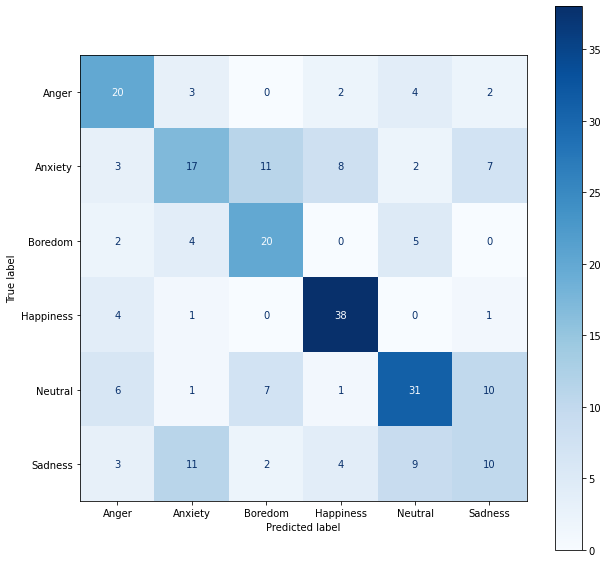

In [54]:
y_pred = lasso.predict(X_test_scaled)
lasso_accuracy = accuracy_score(y_test, y_pred)
lasso_precision = precision_score(y_test, y_pred, average = 'weighted', zero_division = 0)
lasso_recall = recall_score(y_test, y_pred, average = 'weighted', zero_division = 0)
lasso_f1 = f1_score(y_test, y_pred, average = 'weighted', zero_division = 0)

cm = confusion_matrix(y_test, y_pred)

%matplotlib inline
plt.rcParams['figure.figsize'] = [10, 10]
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = class_labels)
disp.plot(cmap = 'Blues')
plt.show()

From the confusion matrices of these two models, it looks like they are pretty accurately predicting the response. Many of the labels are predicted correctly, and the two models seem to give fairly similar results. These will be looked at more in depth in the model evaluation section, but it seems like these are an improvement from the linear regression models.

### Random Forest Classifier

One final model to test out is the random forest classifier. The advantage of this model is that it often has high accuracy, since it combines multiple decisions trees. It also handles non-linear data well, which seems like might be a good fit for this data.

In [55]:
random_forest = RandomForestClassifier(n_estimators = 100, random_state = 123)
random_forest.fit(X_train, y_train)

RandomForestClassifier(random_state=123)

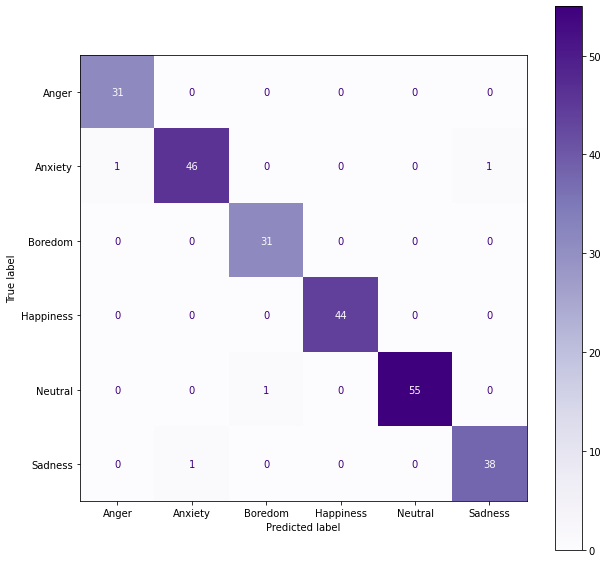

In [56]:
y_pred = random_forest.predict(X_test)
rf_accuracy = accuracy_score(y_test, y_pred)
rf_precision = precision_score(y_test, y_pred, average = 'weighted', zero_division = 0)
rf_recall = recall_score(y_test, y_pred, average = 'weighted', zero_division = 0)
rf_f1 = f1_score(y_test, y_pred, average = 'weighted', zero_division = 0)

cm = confusion_matrix(y_test, y_pred)
%matplotlib inline
plt.rcParams['figure.figsize'] = [10, 10]
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = class_labels)
disp.plot(cmap = 'Purples')
plt.show()

This model clearly predicts the response much more accurately than the lasso and ridge regression models. There are only a few times when this model predicted the response incorrectly, indicating a very good fit.

___

## Evaluating the Models
Now that multiple models have been created, various performance metrics can be used to choose the best model.

### Performance Metrics - Linear Regression
Different performance metrics need to be used for the linear regression models than the classification ones. For linear regression, useful metrics include $R^2$ and adjusted $R^2$, F-statistics, and AIC/BIC.

In [57]:
linear_regression_comparisons = {
    "Model": ["Linear Regression - All Predictors", "Linear Regression - Backward Selection", "Linear Regression - Forward Selection", "Linear Regression - Mixed Selection"], 
    "Number of Predictors": [13, 6, 12, 6],
    "R-Squared": [0.426, 0.424, 0.426, 0.424],
    "Adjusted R-Squared": [0.420, 0.421, 0.420, 0.421],
    "F-Statistic": [66.50, 121.50, 66.50,  121.5],
    "p-value (F-statistics)": ["9.63e-111", "5.73e-115", "9.63e-111", "5.73e-115"],
    "AIC": [1846, 1840, 1846, 1840],
    "BIC": [1905, 1874, 1905, 1874],
}
LR_comparisons_df = pd.DataFrame(linear_regression_comparisons)
LR_comparisons_df

,Model,Number of Predictors,R-Squared,Adjusted R-Squared,F-Statistic,p-value (F-statistics),AIC,BIC
0,Linear Regression - All Predictors,13,0.426,0.420,66.5,9.63e-111,1846,1905
1,Linear Regression - Backward Selection,6,0.424,0.421,121.5,5.73e-115,1840,1874
2,Linear Regression - Forward Selection,12,0.426,0.420,66.5,9.63e-111,1846,1905
3,Linear Regression - Mixed Selection,6,0.424,0.421,121.5,5.73e-115,1840,1874


The first thing to note is that it looks like the mixed selection method may have ended up choosing the same predictors as the backward selection method, since all the performance metrics are the same. This means that maybe backward selection was a good enough method to use for this data, and forward selection wasn't necessary.

The $R^2$ and adjusted $R^2$ values for all four of the lienar regression models are very similar, around 0.42. This indicates that about 42% of the total variance in the response is explained by the model, which is not great. The F-statistics were very high for those models, especially the backward and mixed selection models, which indicates that the predictors in these models represent the data well, but they just might not be linear.

The AIC (Akaike Information Criterion) estimates the quality of the models for the data, with lower values indicating a better model. And the BIC (Bayesian Information Criterion) is similar to AIC but includes a penalty fot the number of parameters. The AIC for all the models is fairly similar, but lower for the backward and mixed selection. The BIC has a wider range since it is penalizing the models with more parameters. Backward and mixed selection have the lowest values for that category as well.

From these metrics, backward and mixed selection seem to have worked best for this data, with backward being prefered since it is simpler to compute. However, none of these models seem to be a great fit with such low $R^2$ values.

### Performance Metrics - Ridge and Lasso Regression and Random Forest Classifier
Now, for the models that aimed to classify emotion into the different classes, different metrics can be used to analyze how well they did so: accuracy, precision, recall, and F1 score. These values are shown for the three other models made here: ridge regression, lasso regression, and random forest classifier.

In [58]:
ridge_lasso_rf_comparisons = {
    "Model": ["Ridge Regression", "Lasso Regression", "Random Forest Classifier"], 
    "Accuracy": [ridge_accuracy, lasso_accuracy, rf_accuracy],
    "Precision": [ridge_precision, lasso_precision, rf_precision],
    "Recall": [ridge_recall, lasso_recall, rf_recall],
    "F1 Score": [ridge_f1, lasso_f1, rf_f1],
    
}

ridge_lasso_rf_comparisons_df = pd.DataFrame(ridge_lasso_rf_comparisons)
ridge_lasso_rf_comparisons_df

,Model,Accuracy,Precision,Recall,F1 Score
0,Ridge Regression,0.554217,0.542265,0.554217,0.540504
1,Lasso Regression,0.546185,0.531953,0.546185,0.533586
2,Random Forest Classifier,0.983936,0.984101,0.983936,0.983918


- Accuracy gives a general feel for model performance, but is sensitive to imbalanced datasets. From the bar graph of the emotion variable earlier, this data does show slight imbalance of classes. Regardless, the accuracy for the random forest classifier is much higher (0.98) than the ridge and lasso regression (~0.55).
- Precision is most useful when trying to avoid false positives, because it looks at true positives. This value is also much higher for random forest classifier than ridge and lasso regression.
- Recall is useful when trying to avoid false negatives, since it looks at all actual positive cases and how many are handels correctly. This value is also much higher for random forest classifier.
- F1 score balances precision and recall, which may be most beneficial to the goal of this project, since it doesn't lean too far either way when it comes to prioritizing true positives vs. true negatives. This score is also much higher for random forest classifier.

___

## Discussion

### Model Selection - Random Forest Classifier
Overall, it is clear that the random forest classifier performed far better than any of the other models. This is likely due to its robustness to collinearity as well as non-linear data, and the fact that it requires less fine tuning than most other models.

Lasso and ridge regression, though they have advantages stated earlier, assume a linear relationship between the predictors and response, which this data may not have. Even if it performed better than the OSL model, the random forest classifier still far out performed all of these models.

### Reflection
There are quite a few things I would have done differently if I were to start this project from the beginning again, as well as things I would do if I had endless time to spend on this project:

- Starting over, I would not have spent so much time on linear regression methods, as I came to realize later than my predictors do not have a linear relationship with the response. 
- I would have plotted my residuals plot for the linear regression models earlier to see this.
- I also would have spent more time on different classification models, like support vector machines (SVM) and K-nearest neighbors (KNN). 
- I would have spent more time trying to get the variance inflation factors (VIF) printing properly, as I spent a lot of time trying to get this to work and was only semi-successful.
- Combining my collinear features into one predictor helped my models significantly, so I would have done this earlier on if I knew.
- Spend more time to iterate my random forest classifier model to improve it.

One issue I also struggled with in this project was how to organize all the data. It is easy to play around with different functions and go back and forth between modelling and feature engineering and data cleaning, but it is much harder to actually organize this data clearly for someone else to understand, without overloading it with too many details.

Overall, there are so many different approaches to supervised learning and an infinite amoutn of time could be spent on these methods. After spending much time with the approaches I chose, I am glad to have found at least one model that was able to predict my data with 98% accuracy. Since this was such an open ended project, I really learned a lot about choosing models based on the type of data I am given, including the most important information and making informed decisions, and even learning about the different kinds of data that is available out there. 